# Visualization & Style Transfer


In [1]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension 
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]
    
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

# Visualize Convolutional Neural Networks

## Visualize the input

Image shape: (1, 270, 512, 3)


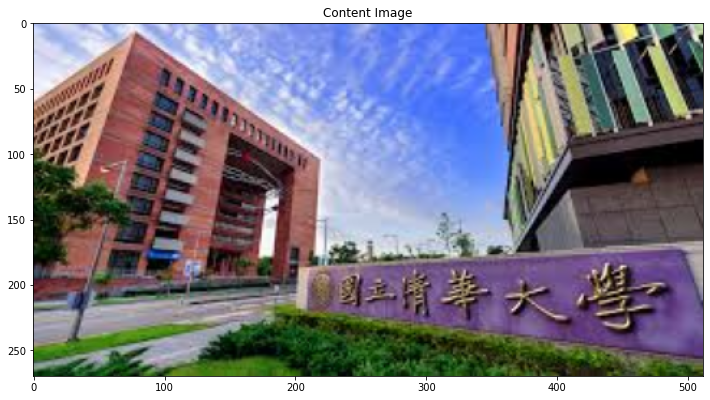

In [5]:
content_path = './dataset/content_nthu.jpg'
content_image = load_img(content_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

## Load a pretrained network (VGG19)

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))

# load pretrained network(VGG19)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [7]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('library', 0.29123938),
 ('flagpole', 0.073582016),
 ('planetarium', 0.06436771),
 ('picket_fence', 0.048106086),
 ('church', 0.046793193)]

In [8]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualize filters

In [9]:
# summarize filter shapes
for layer in vgg.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)


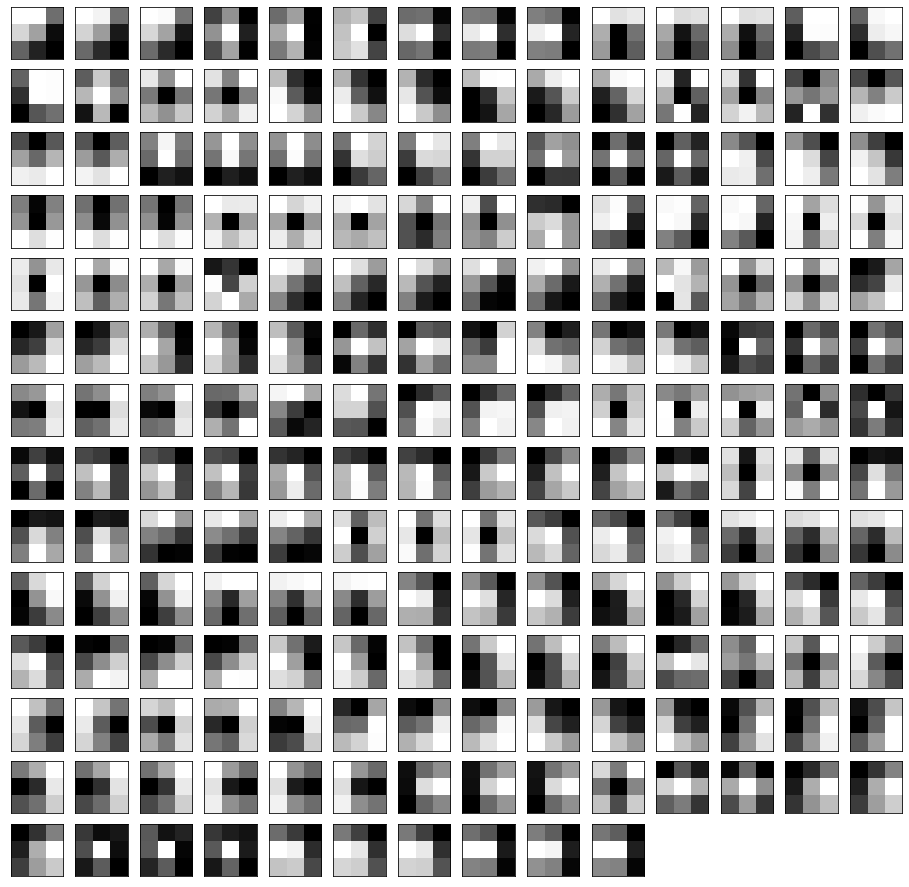

In [10]:
plt.figure(figsize=(16,16))

# retrieve weights from the second hidden layer
filters, biases = vgg.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 64, 1

for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(14, 14, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

## Visualize feature maps

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


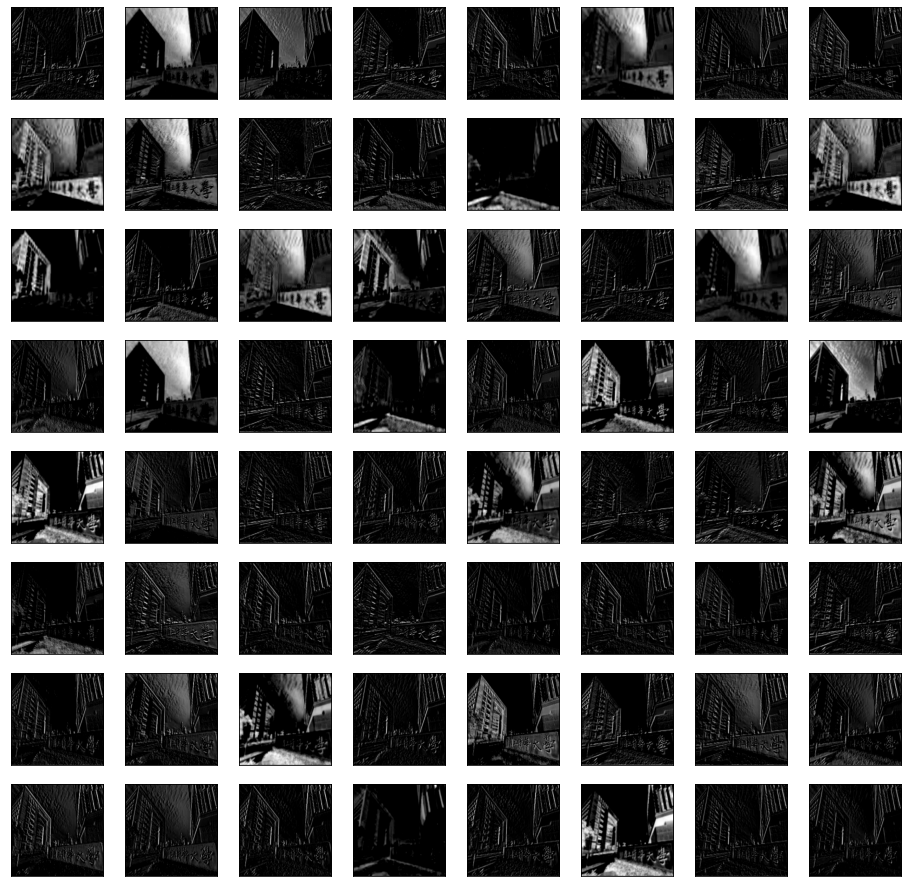

In [11]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[1].output)
model.summary()

# preprocess input
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (224, 224))

# get feature map for first hidden layer
feature_maps = model.predict(content_image)

# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
        
# show the figure
pyplot.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")


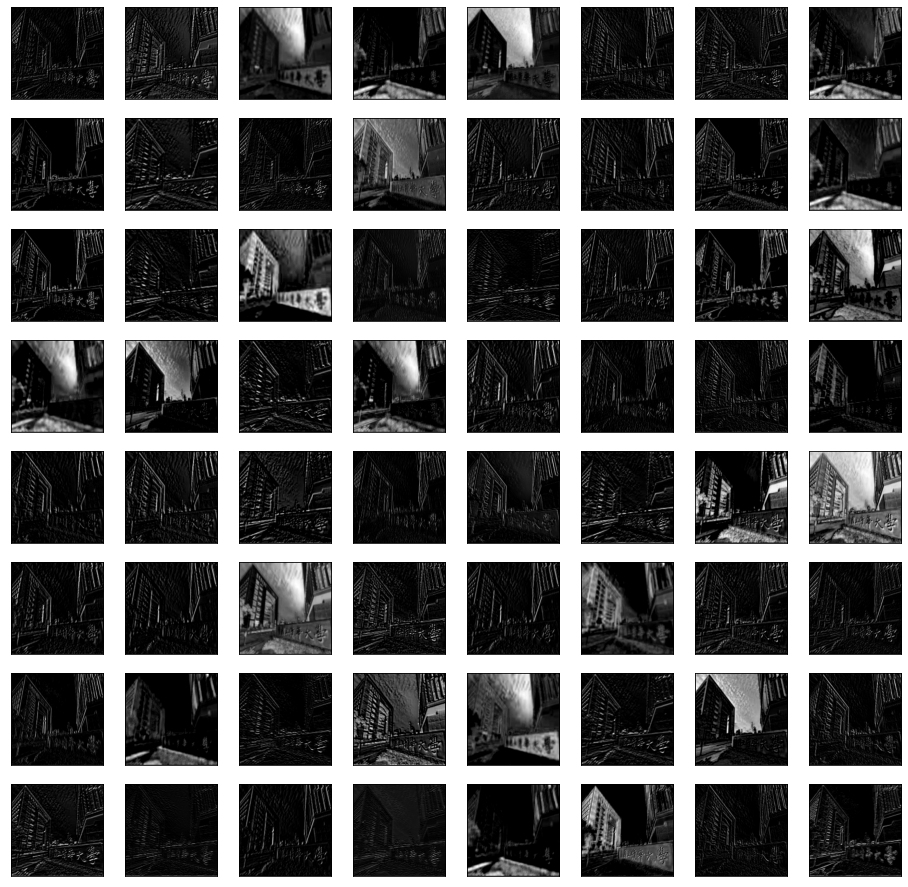

KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")


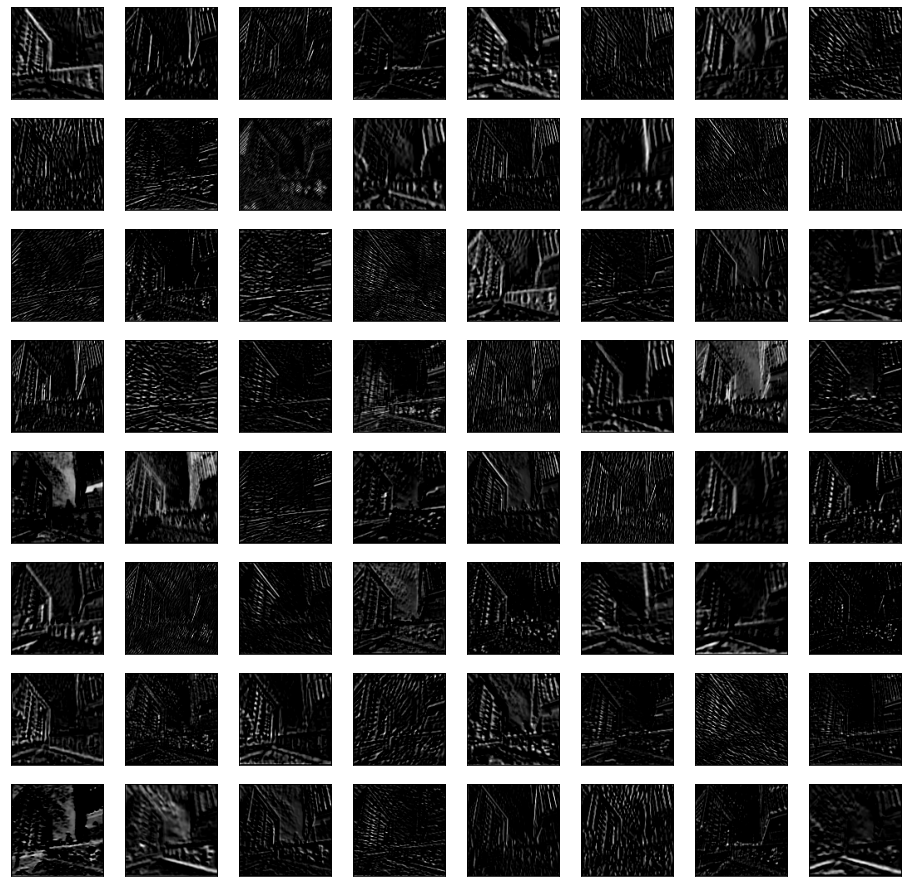

KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='block3_conv4/Relu:0', description="created by layer 'block3_conv4'")


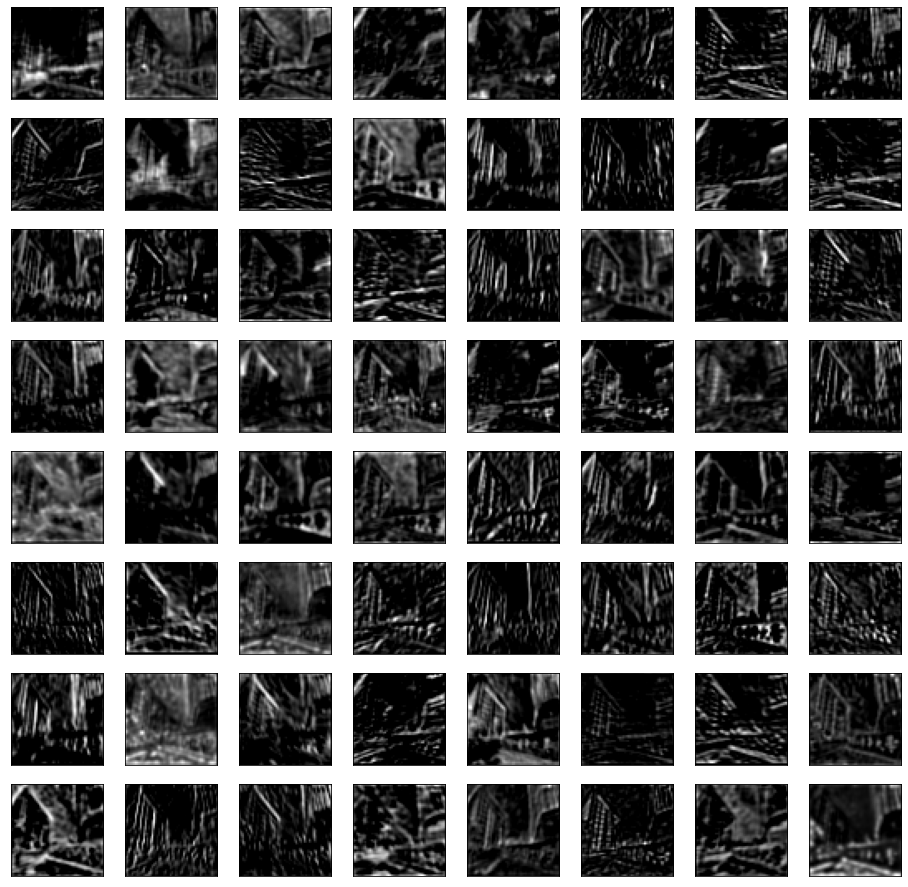

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='block4_conv4/Relu:0', description="created by layer 'block4_conv4'")


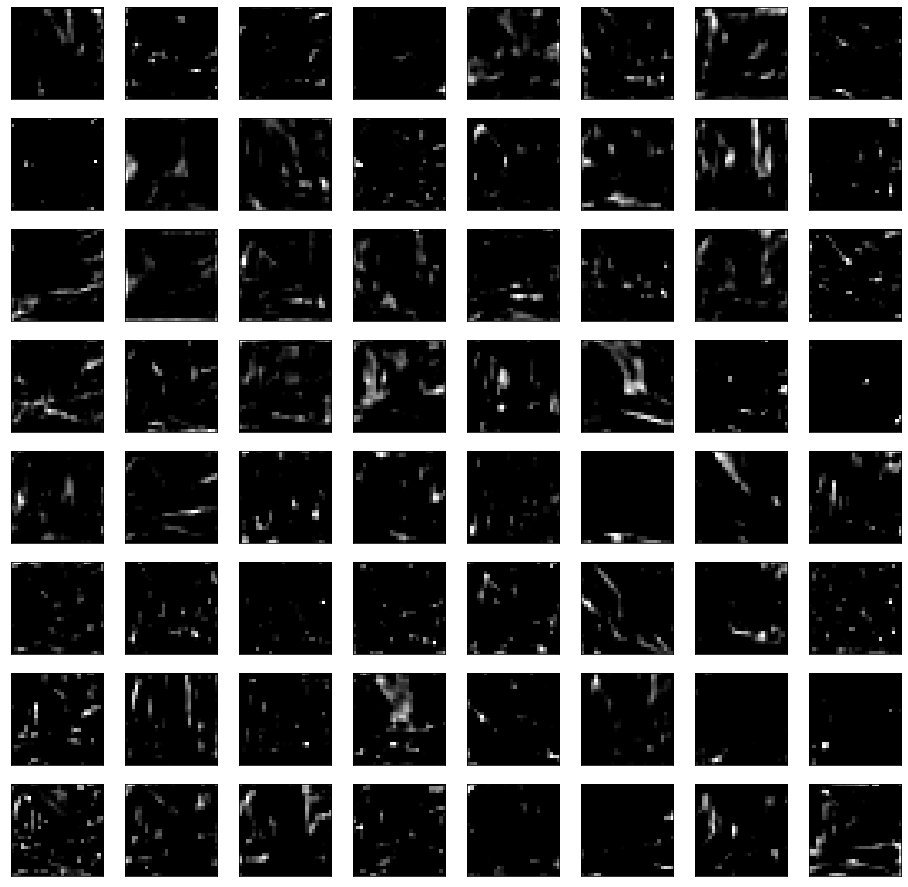

KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 512), dtype=tf.float32, name=None), name='block5_conv4/Relu:0', description="created by layer 'block5_conv4'")


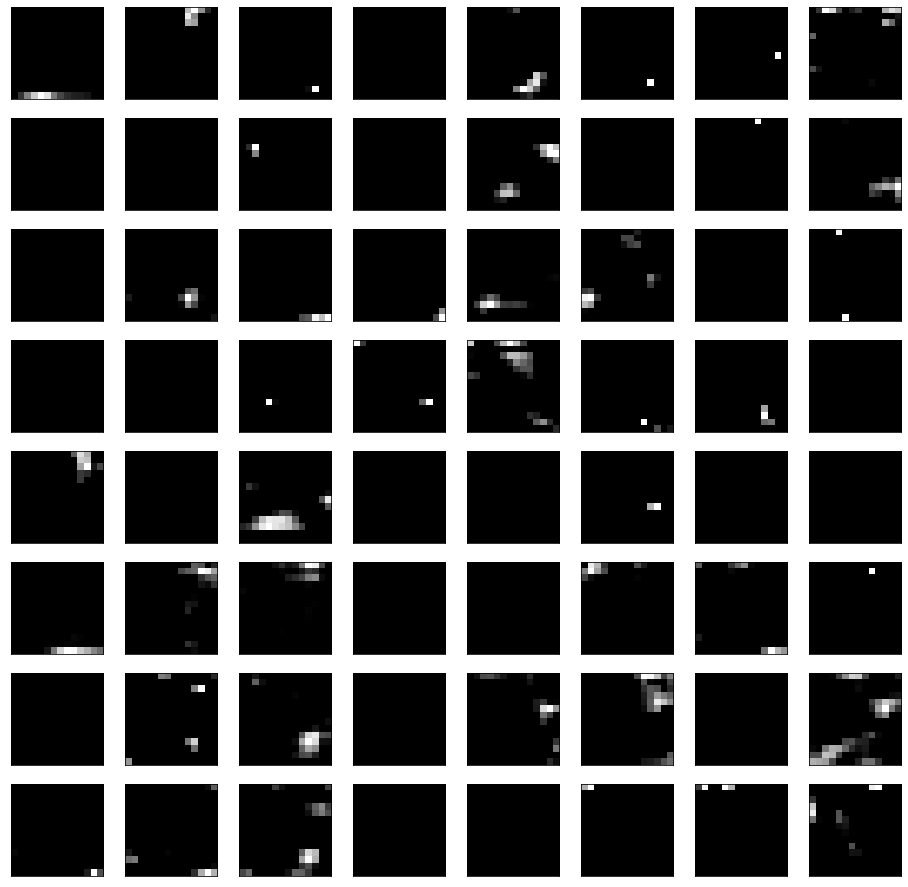

In [12]:
# get feature maps for last convolutional layer in each block
ixs = [2, 5, 10, 15, 20]
outputs = [vgg.layers[i].output for i in ixs]
model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)
feature_maps = model.predict(content_image)

# plot the output from each block
square = 8
for i, fmap in enumerate(feature_maps):
    # plot all 64 maps in an 8x8 squares
    ix = 1
    print(outputs[i])
    plt.figure(figsize=(16,16))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
            
    # show the figure
    pyplot.show()

## Visualize gradients


In [13]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [14]:
class GradientModel(tf.keras.models.Model):
    def __init__(self, layers):
        super(GradientModel, self).__init__()
        self.vgg =  vgg_layers(layers)
        self.num_style_layers = len(layers)
        self.vgg.trainable = False
        
    # return the feature map of required layer
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs

In [15]:
@tf.function()
def visualize_gradient(image):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        # grad = d_feature/d_image
        grad = tape.gradient(tf.reduce_max(feature, axis=3), image)
    return grad

In [16]:
content_image = load_img(content_path)

# activation layer
layers = ['block4_conv2']
image = tf.Variable(content_image)

extractor = GradientModel(layers)
grad = visualize_gradient(image)

# look at the range of gradients
print("shape: ", grad.numpy().shape)
print("min: ", grad.numpy().min())
print("max: ", grad.numpy().max())
print("mean: ", grad.numpy().mean())

shape:  (1, 270, 512, 3)
min:  -18244.418
max:  17163.223
mean:  -15.284504


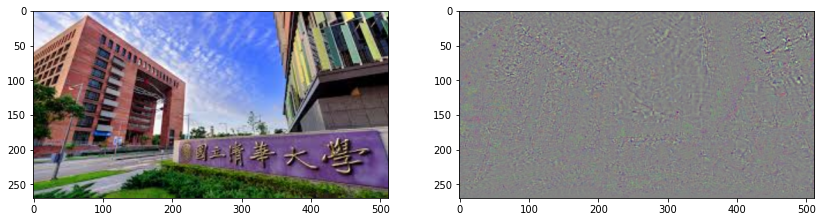

In [17]:
# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])

In [18]:
@tf.function()
def visualize_gradient_single_layer(image, layer_i):
    with tf.GradientTape() as tape:
        feature = extractor(image)
        grad = tape.gradient(tf.reduce_mean(feature[:, :, :, layer_i]), image)
    return grad

<Figure size 1008x720 with 0 Axes>

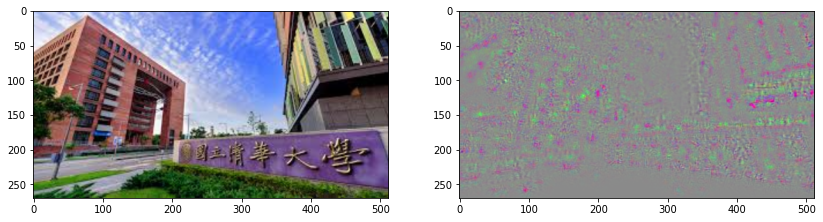

In [19]:
plt.figure(figsize=(14,10))

grad = visualize_gradient_single_layer(image, 77)

# normalize filter values to 0-1 so we can visualize them
g_min, g_max = grad.numpy().min(), grad.numpy().max()
filters = (grad - g_min) / (g_max - g_min)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(image.read_value()[0])

plt.subplot(1, 2, 2)
imshow(filters[0])

# A Neural Algorithm of Artistic Style

## Define content and style representations


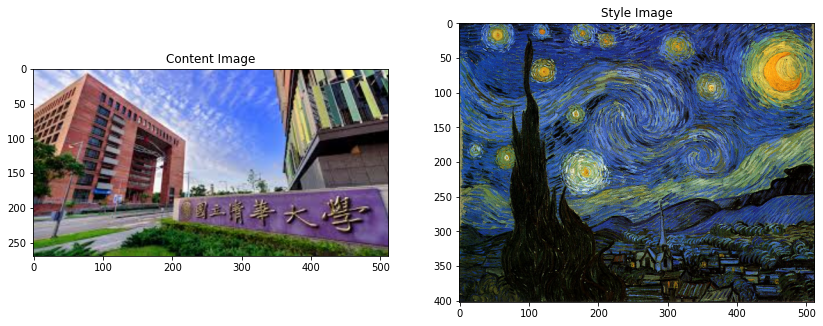

In [4]:
content_path = './dataset/content_nthu.jpg'
style_path = './dataset/style_starry_night.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(14,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [5]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [6]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the Model

In [7]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [8]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 402, 512, 64)
  min:  0.0
  max:  742.4454
  mean:  22.595304

block2_conv1
  shape:  (1, 201, 256, 128)
  min:  0.0
  max:  3492.056
  mean:  139.87125

block3_conv1
  shape:  (1, 100, 128, 256)
  min:  0.0
  max:  6940.3765
  mean:  147.91318

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  15697.715
  mean:  543.7416

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4195.864
  mean:  47.641136



## Calculate Style

In [9]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content

In [10]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [11]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.023810942
    max:  18674.475
    mean:  743.5257

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  111471.79
    mean:  20621.188

   block3_conv1
    shape:  (1, 256, 256)
    min:  1.0352991
    max:  739126.1
    mean:  21373.393

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5888398.5
    mean:  287949.28

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  114889.21
    mean:  2506.202

Contents:
   block5_conv2
    shape:  (1, 16, 32, 512)
    min:  0.0
    max:  942.2922
    mean:  18.336666


## Define Loss

In [12]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Run Gradient Descent

In [13]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [14]:
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # tape.gradient: d_loss/d_image
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

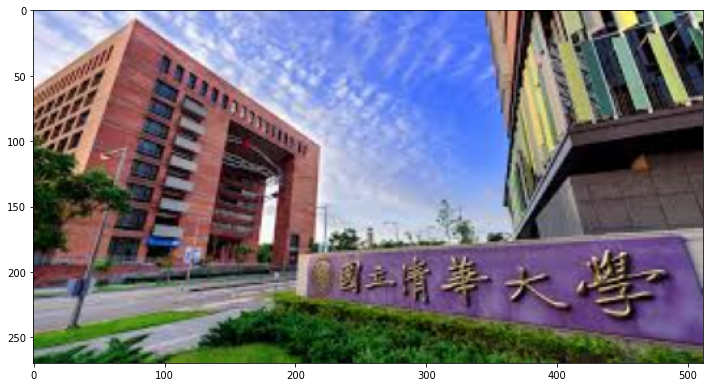

In [15]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight = 0
content_weight = 0

train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

In [16]:
# import time
# start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    print(n)
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
imshow(image.read_value())
plt.title("Train step: {}".format(step))
plt.show()
    

# end = time.time()
# print("Total time: {:.1f}".format(end-start))

0


## Total variation loss

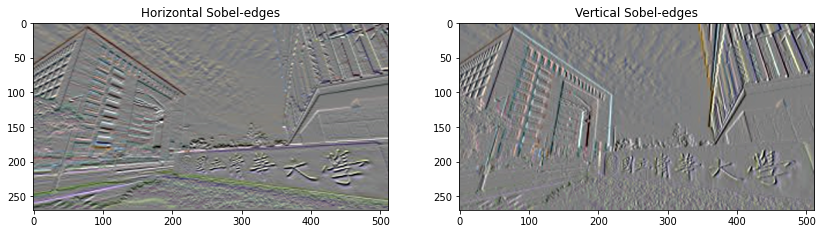

In [31]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [44]:
def total_variation_loss(image):
    image = image[0]
    loss = 0.0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if i+1 < image.shape[0] and j+1 < image.shape[1]:
                loss += np.sum(abs(image[i+1][j] - image[i][j])) + np.sum(abs(image[i][j+1] - image[i][j]))
    return loss

# total_variation_loss(image)

## Re-run the optimization

In [34]:
total_variation_weight = 0

In [35]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [36]:
image = tf.Variable(content_image)

In [ ]:
# start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

# end = time.time()
# print("Total time: {:.1f}".format(end-start))

In [ ]:
file_name = './dataset/style_transfer_nthu_starry_night.png'
mpl.image.imsave(file_name, image[0].numpy())

# AdaIN

In [ ]:
%matplotlib inline

CONTENT_DIRS = ['./dataset/mscoco/test2014']
STYLE_DIRS = ['./dataset/wikiart/test']

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

In [ ]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)

    plt.figure(figsize=(2*col, 2*row))
    for i in range(row*col):
        im = Image.open(paths[i])
        w, h = im.size

        plt.subplot(row, col, i+1)
        plt.imshow(im)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{w}x{h}')
    plt.show()

print('Sampled content images:')
plot_images(CONTENT_DIRS[0], 4, 8, pattern='*.jpg')

print('Sampled style images:')
plot_images(STYLE_DIRS[0], 4, 8, pattern='*.jpg')

## Dataset API

In [ ]:
def clean(dir_path, min_shape=None):
    paths = Path(dir_path).glob('**/*.jpg')
    deleted  = 0
    for path in paths:
        try:
            # Make sure we can decode the image
            im = tf.io.read_file(str(path.resolve()))
            im = tf.image.decode_jpeg(im)

            # Remove grayscale images 
            shape = im.shape
            if shape[2] < 3:
                path.unlink()
                deleted += 1

            # Remove small images
            if min_shape is not None:
                if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
                    path.unlink()
                    deleted += 1
        except Exception as e:
            path.unlink()
            deleted += 1
    return deleted

for dir in CONTENT_DIRS:
    deleted = clean(dir)
print(f'#Deleted content images: {deleted}')

for dir in STYLE_DIRS:
    deleted = clean(dir)
print(f'#Deleted style images: {deleted}')

In [ ]:
def preprocess_image(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.image.random_crop(image, size=IMG_SHAPE)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def np_image(image):
    image += (103.939, 116.779, 123.68) # BGR means
    image = image[..., ::-1] # BGR to RGB
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, dtype='uint8')
    return image.numpy()

def build_dataset(num_gpus=1):
    c_paths = []
    for c_dir in CONTENT_DIRS:
        c_paths += Path(c_dir).glob('*.jpg')
    c_paths = [str(path.resolve()) for path in c_paths]
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print('done')
    return ds

In [ ]:
ds = build_dataset()
c_batch, s_batch = next(iter(ds.take(1)))

print('Content batch shape:', c_batch.shape)
print('Style batch shape:', s_batch.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np_image(c_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Content')

plt.subplot(1, 2, 2)
plt.imshow(np_image(s_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Style')

plt.show()

## Adaptive Instance Normalization

In [5]:
class AdaIN(tf.keras.layers.Layer):
    # TODO
    # Normalized_c, epsilon
    pass

## Model

In [ ]:
class ArbitraryStyleTransferNet(tf.keras.Model):
    CONTENT_LAYER = 'block4_conv1'
    STYLE_LAYERS = ('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1')

    @staticmethod
    def declare_decoder():
        a_input = tf.keras.Input(shape=(28, 28, 512), name='input_adain')

        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(a_input)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        output = tf.keras.layers.Conv2DTranspose(3, 3, padding='same')(h)

        return tf.keras.Model(inputs=a_input, outputs=output, name='decoder')
  
    def __init__(self,
                 img_shape=(224, 224, 3),
                 content_loss_weight=1,
                 style_loss_weight=10,
                 name='arbitrary_style_transfer_net',
                 **kwargs):
        super(ArbitraryStyleTransferNet, self).__init__(name=name, **kwargs)

        self.img_shape = img_shape
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        
        vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape)
        vgg19.trainable = False

        c_output = [vgg19.get_layer(ArbitraryStyleTransferNet.CONTENT_LAYER).output]
        s_outputs = [vgg19.get_layer(name).output for name in ArbitraryStyleTransferNet.STYLE_LAYERS]
        self.vgg19 = tf.keras.Model(inputs=vgg19.input, outputs=c_output+s_outputs, name='vgg19')
        self.vgg19.trainable = False

        self.adain = AdaIN(name='adain')
        self.decoder = ArbitraryStyleTransferNet.declare_decoder()
  
    def call(self, inputs):
        c_batch, s_batch = inputs

        c_enc = self.vgg19(c_batch)
        c_enc_c = c_enc[0]

        s_enc = self.vgg19(s_batch)
        s_enc_c = s_enc[0]
        s_enc_s = s_enc[1:] 
        
        # normalized_c is the output of AdaIN layer
        normalized_c = self.adain((c_enc_c, s_enc_c))
        output = self.decoder(normalized_c)

        # Calculate loss
        out_enc = self.vgg19(output)
        out_enc_c = out_enc[0]
        out_enc_s = out_enc[1:]

        loss_c = tf.reduce_mean(tf.math.squared_difference(out_enc_c, normalized_c))
        self.add_loss(self.content_loss_weight * loss_c)
        
        loss_s = 0
        for o, s in zip(out_enc_s, s_enc_s):    
            o_mean, o_var = tf.nn.moments(o, axes=(1,2), keepdims=True)
            o_std = tf.sqrt(o_var + self.adain.epsilon)

            s_mean, s_var = tf.nn.moments(s, axes=(1,2), keepdims=True)
            s_std = tf.sqrt(s_var + self.adain.epsilon)

            loss_mean = tf.reduce_mean(tf.math.squared_difference(o_mean, s_mean))
            loss_std = tf.reduce_mean(tf.math.squared_difference(o_std, s_std))

            loss_s += loss_mean + loss_std
        self.add_loss(self.style_loss_weight * loss_s)

        return output, c_enc_c, normalized_c, out_enc_c

In [ ]:
# Plot results
def plot_outputs(outputs, captions=None, col=5):
    row = len(outputs)
    plt.figure(figsize=(3*col, 3*row))
    for i in range(col):
        for j in range(row):
            plt.subplot(row, col, j*col+i+1)
            plt.imshow(np_image(outputs[j][i,...,:3]))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if captions is not None:
                plt.xlabel(captions[j])
    plt.show()

In [ ]:
ds = build_dataset()
model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)

c_batch, s_batch = next(iter(ds.take(1)))
print(f'Input shape: ({c_batch.shape}, {s_batch.shape})')
output, *_ = model((c_batch, s_batch))
print(f'Output shape: {output.shape}')
print(f'Init. content loss: {model.losses[0]:,.2f}, style loss: {model.losses[1]:,.2f}')
model.summary()

## Training

In [ ]:
# Train the model
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
c_loss_metric, s_loss_metric = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

CKP_DIR = 'checkpoints'
init_epoch = 1

ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    model.load_weights(ckp)
    init_epoch = int(ckp.split('_')[-1]) + 1
    print(f'Resume training from epoch {init_epoch-1}')

In [ ]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        model(inputs)
        c_loss, s_loss = model.losses
        loss = c_loss + s_loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    c_loss_metric(c_loss)
    s_loss_metric(s_loss)

In [ ]:
def train(dataset, init_epoch):
    for epoch in range(init_epoch, EPOCHS+1):
        print(f'Epoch {epoch:>2}/{EPOCHS}')
        for step, inputs in enumerate(ds.take(STEPS_PER_EPOCH)):
            train_step(inputs)
            print(f'{step+1:>5}/{STEPS_PER_EPOCH} - loss: {c_loss_metric.result()+s_loss_metric.result():,.2f} - content loss: {c_loss_metric.result():,.2f} - style loss: {s_loss_metric.result():,.2f}', end='\r') 

        print()
        model.save_weights(os.path.join(CKP_DIR, f'ckpt_{epoch}'))
        c_loss_metric.reset_states()
        s_loss_metric.reset_states()

        output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
        plot_outputs((s_batch, c_batch, output, c_enc_c, normalized_c, out_enc_c), 
                     ('Style', 'Content', 'Trans', 'Content Enc', 'Normalized', 'Trans Enc'))

In [ ]:
train(ds, init_epoch)

## Testing

In [ ]:
CKP_DIR = 'checkpoints/ckpt_20'

model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)
model.load_weights(CKP_DIR)

ds = build_dataset()

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 1:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    print('Recovered loss:', tf.reduce_sum(model.losses).numpy())

    plot_outputs((s_batch, c_batch, output), ('Style', 'Content', 'Trans'))

## NTHU example

In [ ]:
def preprocess_example(path, init_shape=(IMG_SHAPE[0], IMG_SHAPE[1])):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, init_shape)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def nthu_example(num_gpus=1):
    c_paths = ['./dataset/content_nthu.jpg']
    
    s_paths = []
    for s_dir in STYLE_DIRS:
        s_paths += Path(s_dir).glob('*.jpg')
    s_paths = [str(path.resolve()) for path in s_paths]
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_example, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)
    
    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    print('done')
    return ds

In [ ]:
ds = nthu_example()
outputs = []

for idx, (c_batch, s_batch) in enumerate(ds):
    if idx > 4:
        break
    output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
    outputs.append(output)
    
plot_outputs((outputs))

# Save and Load Models